In [1]:
import os
import pandas as pd
import numpy as np
from pipeline import ClusterFeatures,LBP_3D

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report,roc_auc_score



In [2]:

def XGBoost(X_tr, Y_tr, X_te, Y_te,quick=False):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
    }

    # Create the model
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        tree_method='hist',
        random_state=42
    )

    if quick:
            best_model = xgb_model
            best_model.fit(X_tr, Y_tr)

            xgb_pred = best_model.predict(X_te)


            ConfusionMatrixDisplay.from_estimator(estimator=best_model, X=X_te, y=Y_te)

            print("Classification Report: XGBoost")
            report = classification_report(Y_te, xgb_pred, digits=2)
            print(report)
            return best_model


    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='accuracy',  
        cv=10,  
        verbose=1,
        n_jobs=-1  
    )

  
    grid_search.fit(X_tr, Y_tr)

   
    best_model = grid_search.best_estimator_
    best_model.fit(X_tr, Y_tr)

    xgb_pred = best_model.predict(X_te)

    ConfusionMatrixDisplay.from_estimator(estimator=best_model, X=X_te, y=Y_te)

    print("Classification Report: XGBoost")
    report = classification_report(Y_te, xgb_pred, digits=2)
    print(report)
    return best_model
def XGBoostP(X_tr, Y_tr, X_te, Y_te,quick=False):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
    }

    # Create the model
    xgb_model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        tree_method='hist',
        random_state=42
    )

    if quick:
            best_model = xgb_model
            best_model.fit(X_tr, Y_tr)

            xgb_pred = best_model.predict(X_te)
            xgb_prob = best_model.predict_proba(X_te)
            for y,a,b in zip(Y_te,xgb_pred,xgb_prob):
                  print(y,a,b)

            xgb_prob=[max(a) for a in xgb_prob]

           
            
            ConfusionMatrixDisplay.from_estimator(estimator=best_model, X=X_te, y=Y_te,sample_weight=xgb_prob)


            return best_model


    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='accuracy',  
        cv=10,  
        verbose=1,
        n_jobs=-1  
    )

  
    grid_search.fit(X_tr, Y_tr)

   
    best_model = grid_search.best_estimator_
    best_model.fit(X_tr, Y_tr)

    xgb_pred = best_model.predict(X_te)
    

    ConfusionMatrixDisplay.from_estimator(estimator=best_model, X=X_te, y=Y_te)

    print("Classification Report: XGBoost")
    report = classification_report(Y_te, xgb_pred, digits=2)
    print(report)
    return best_model
def RF(X_tr, Y_tr, X_te, Y_te):

    param_grid = {
        'n_estimators': [int(x) for x in np.linspace(start=10, stop=100, num=10)],  
        'max_depth': range(1, 20),  
        'criterion': ['gini', 'entropy'] 
    }


    optimal_params = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=10, 
        scoring='accuracy',
        verbose=0,
        n_jobs=-1
    )


    optimal_params.fit(X_tr, Y_tr)
    print("Best parameters found: ", optimal_params.best_params_)


    criterion = optimal_params.best_params_['criterion']
    max_depth = optimal_params.best_params_['max_depth']
    n_estimators = optimal_params.best_params_['n_estimators']


    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        criterion=criterion,
        random_state=42
    )

    rf_model.fit(X_tr, Y_tr)


    rf_pred = rf_model.predict(X_te)


    ConfusionMatrixDisplay.from_estimator(estimator=rf_model, X=X_te, y=Y_te)

    print("Best Cross-Validation Score:",optimal_params.best_score_)
    print("Classification Report: Random Forest")
    print(classification_report(Y_te, rf_pred, digits=2))
    return rf_model


In [3]:

csv_dir = '../Datasets/Rat PA Study/CSV/'
csv_files = [file for file in os.listdir(csv_dir) if file.endswith('.csv')]

dataframes = []
for file in csv_files:
    file_path = os.path.join(csv_dir, file)
    dataframes.append([pd.read_csv(file_path),file_path])

d7=[]
d14=[]
d21=[]

for d in dataframes.copy():
    if 'PA7' in d[1]:
        d7.append(d)
    
    if 'PA14' in d[1]:
        d14.append(d)
    
    if 'PA21' in d[1]:
        d21.append(d)
    


print(len(d7),len(d14),len(d21))

12 18 22


In [ ]:
data=[]
for d,p in d21:
    name=p.split('_XV')[0]+'_XV'
    name=name.split('/')[-1]
    d.columns=['SV','X','Y','Z']
    if 'WT' in p:
        
        data.append([d,0])
    elif 'KO' in p:
        data.append([d,1])
    else:
        data.append([d,2])


lbp=LBP_3D(data)
features=lbp.extract()

: 

In [5]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

NameError: name 'features' is not defined

In [4]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)

modelLBP=XGBoost(X_train,y_train,X_test,y_test,True)
modelLBPP=XGBoostP(X_train,y_train,X_test,y_test,True)

NameError: name 'features' is not defined

In [ ]:

c=ClusterFeatures(data)
features=c.extract()

/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but K

: 

In [ ]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

: 

Classification Report: XGBoost
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      1.00      0.67         2
           2       0.00      0.00      0.00         1

    accuracy                           0.40         5
   macro avg       0.17      0.33      0.22         5
weighted avg       0.20      0.40      0.27         5

0 2 [0.01709551 0.01080345 0.97210103]
0 1 [0.05263984 0.7613207  0.1860394 ]
2 1 [0.03245144 0.86048126 0.10706735]
1 1 [0.06950681 0.8817591  0.04873415]
1 1 [0.18631996 0.72114104 0.09253898]


/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

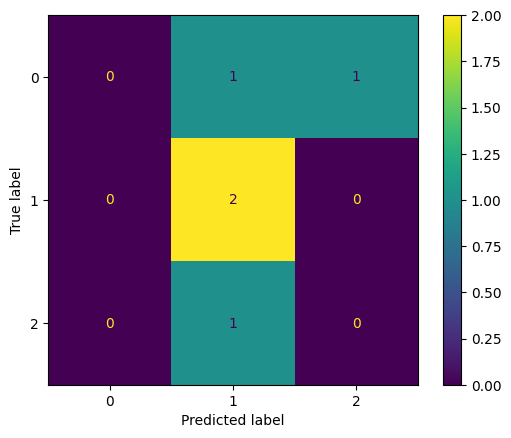

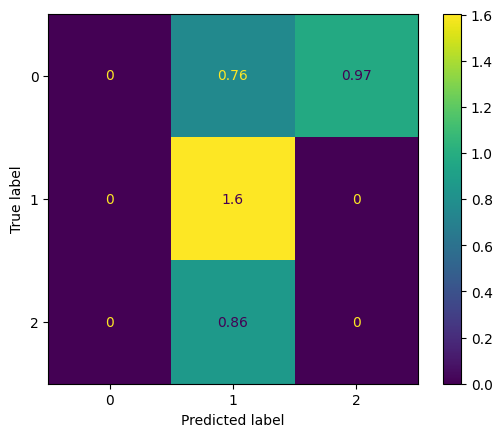

: 

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)

model=XGBoost(X_train,y_train,X_test,y_test,True)
modelP=XGBoostP(X_train,y_train,X_test,y_test,True)

In [ ]:
data=[]
for d,p in d14:
    name=p.split('_XV')[0]+'_XV'
    name=name.split('/')[-1]
    d.columns=['SV','X','Y','Z']
    if 'WT' in p:
        
        data.append([d,0])
    elif 'KO' in p:
        data.append([d,1])
    else:
        data.append([d,2])



lbp=LBP_3D(data)
features=lbp.extract()

: 

In [ ]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

: 

Classification Report: XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.50      1.00      0.67         1
           2       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.50      0.67      0.56         4
weighted avg       0.62      0.75      0.67         4

0 0 [0.46489248 0.10794672 0.42716086]
1 1 [0.08841852 0.8122192  0.09936225]
0 0 [0.52512383 0.10972285 0.36515334]
2 1 [0.20591663 0.7665738  0.02750957]


/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

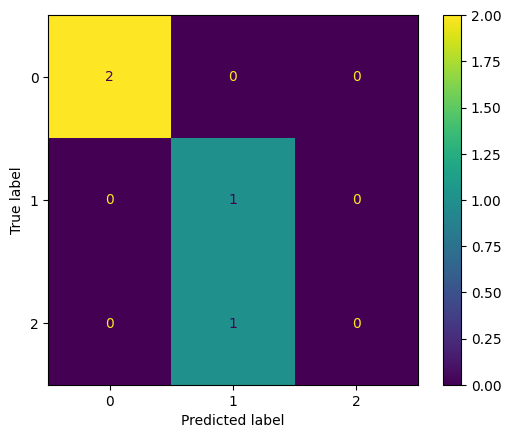

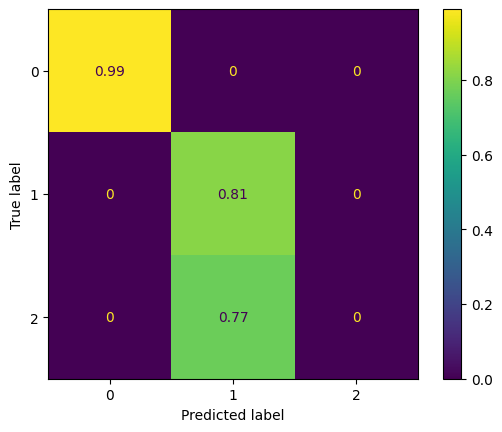

: 

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)

modelLBP=XGBoost(X_train,y_train,X_test,y_test,True)
modelLBPP=XGBoostP(X_train,y_train,X_test,y_test,True)

In [ ]:

c=ClusterFeatures(data)
features=c.extract()

/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but K

: 

In [ ]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

: 

Classification Report: XGBoost
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.50      1.00      0.67         1
           2       0.00      0.00      0.00         1

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.44         4
weighted avg       0.62      0.50      0.50         4

0 0 [0.98579454 0.00623795 0.00796752]
1 1 [0.2673022  0.6961757  0.03652213]
0 2 [0.02418712 0.05764366 0.9181692 ]
2 1 [0.11448215 0.8624203  0.02309757]


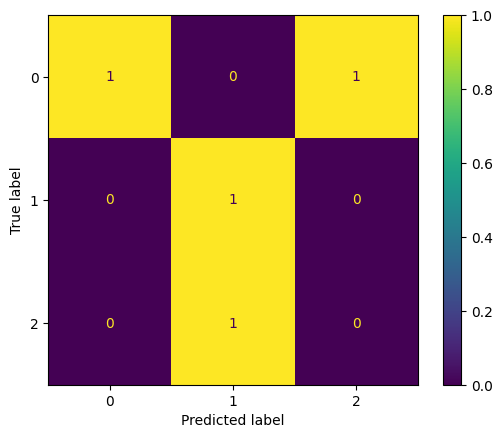

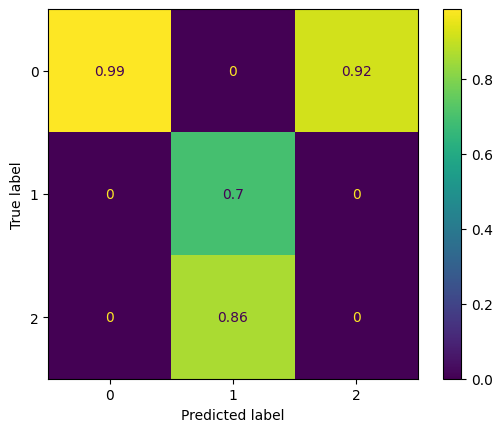

: 

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)

model=XGBoost(X_train,y_train,X_test,y_test,True)
modelP=XGBoostP(X_train,y_train,X_test,y_test,True)

In [ ]:
data=[]
for d,p in d7:
    name=p.split('_XV')[0]+'_XV'
    name=name.split('/')[-1]
    d.columns=['SV','X','Y','Z']
    if 'WT' in p:
        
        data.append([d,0])
    elif 'KO' in p:
        data.append([d,1])
    else:
        data.append([d,2])



lbp=LBP_3D(data)
features=lbp.extract()

: 

In [ ]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

: 

Classification Report: XGBoost
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.11      0.33      0.17         3
weighted avg       0.11      0.33      0.17         3

2 2 [0.40907723 0.04542767 0.5454951 ]
1 2 [0.40307862 0.16006102 0.43686038]
0 2 [0.06690078 0.10379692 0.82930225]


/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

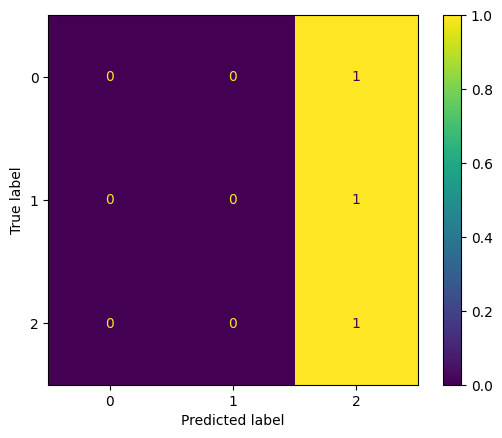

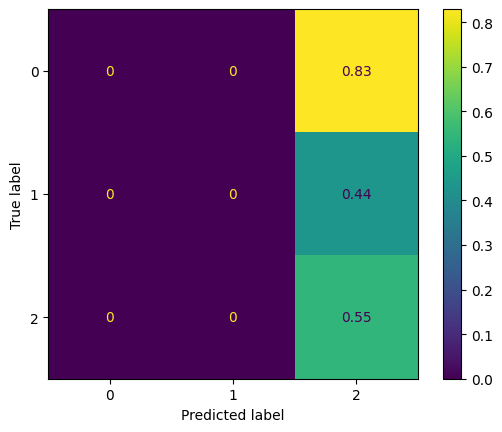

: 

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)

modelLBP=XGBoost(X_train,y_train,X_test,y_test,True)
modelLBPP=XGBoostP(X_train,y_train,X_test,y_test,True)

In [ ]:

c=ClusterFeatures(data)
features=c.extract()

/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but K

: 

In [ ]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

: 

Classification Report: XGBoost
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.33      0.33      0.33         3
weighted avg       0.33      0.33      0.33         3

2 0 [0.7856304  0.11062266 0.10374697]
1 1 [0.28101078 0.44100535 0.27798393]
0 2 [0.38615465 0.08947533 0.52437   ]


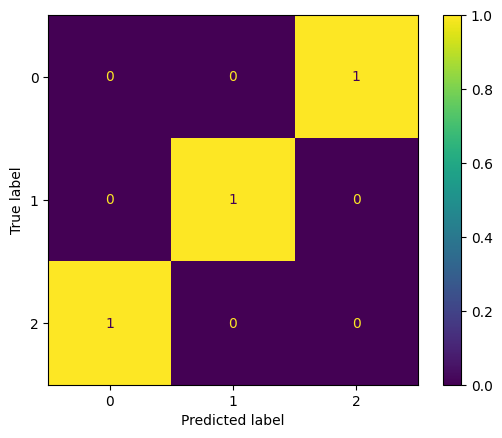

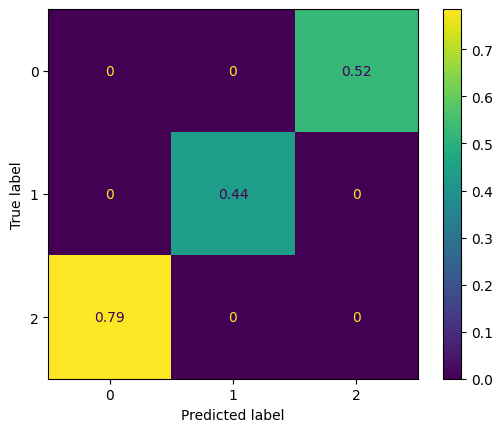

: 

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)

model=XGBoost(X_train,y_train,X_test,y_test,True)
modelP=XGBoostP(X_train,y_train,X_test,y_test,True)

In [ ]:
data=[]

for d,p in dataframes:
    name=p.split('_XV')[0]+'_XV'
    name=name.split('/')[-1]
    d=d.drop(columns=['gCluster','lCluster'])
    d.columns=['SV','X','Y','Z']
    if 'WT' in p:
        
        data.append([d,0])
    elif 'KO' in p:
        data.append([d,1])
    else:
        data.append([d,2])



lbp=LBP_3D(data)
features=lbp.extract()

: 

In [ ]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

: 

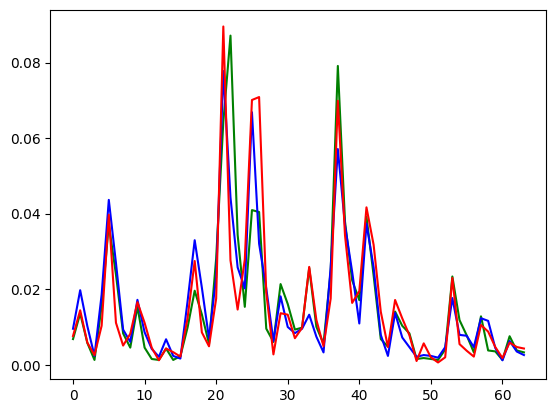

: 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(features.T[0],color='green')
plt.plot(features.T[3],color='blue')
plt.plot(features.T[5],color='red')


Classification Report: XGBoost
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.57      1.00      0.73         4
           2       0.00      0.00      0.00         3

    accuracy                           0.55        11
   macro avg       0.41      0.50      0.43        11
weighted avg       0.45      0.55      0.47        11

0 1 [0.13847913 0.7971151  0.06440579]
1 1 [0.10075555 0.8276826  0.07156181]
0 2 [0.23513015 0.01194303 0.75292677]
1 1 [0.03154099 0.94783884 0.02062018]
0 0 [0.71244055 0.05357703 0.2339824 ]
1 1 [0.05044423 0.90901285 0.04054292]
2 1 [0.03077098 0.9420963  0.02713271]
1 1 [0.08229924 0.88899606 0.02870466]
2 1 [0.06207954 0.54878944 0.389131  ]
0 0 [0.6045811  0.26738152 0.12803736]
2 0 [0.5136208  0.14391373 0.34246546]


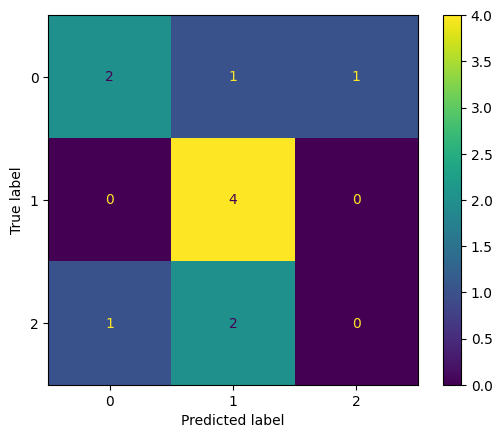

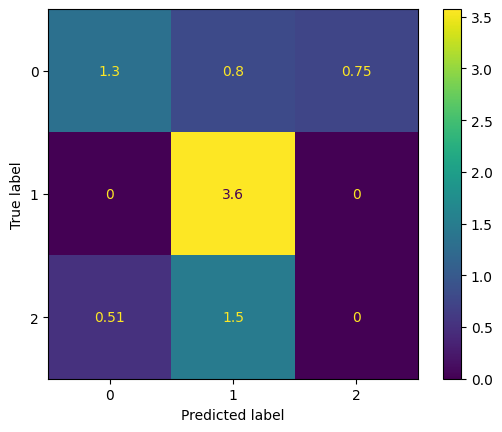

: 

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)

modelLBP=XGBoost(X_train,y_train,X_test,y_test,True)
modelLBPP=XGBoostP(X_train,y_train,X_test,y_test,True)

In [ ]:

c=ClusterFeatures(data)
features=c.extract()

/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but K

: 

In [ ]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

: 

Classification Report: XGBoost
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         4
           1       0.00      0.00      0.00         4
           2       0.25      0.33      0.29         3

    accuracy                           0.27        11
   macro avg       0.19      0.28      0.23        11
weighted avg       0.19      0.27      0.22        11

0 1 [0.03280746 0.7590287  0.20816389]
1 0 [0.73562557 0.1511302  0.11324425]
0 2 [0.2445301  0.10086391 0.65460604]
1 2 [0.08931153 0.09510951 0.81557894]
0 0 [0.8396205  0.11083665 0.04954285]
1 0 [0.5438415  0.44233653 0.013822  ]
2 2 [0.01415339 0.02739362 0.958453  ]
1 2 [0.10031686 0.14457932 0.7551038 ]
2 0 [0.4224387  0.38668564 0.19087568]
0 0 [0.9621574  0.02090308 0.01693945]
2 0 [0.5812407 0.1414429 0.2773164]


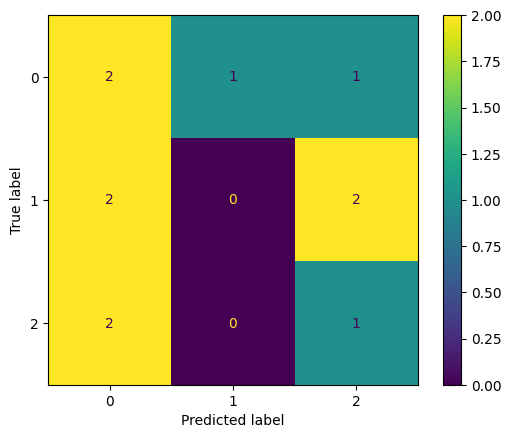

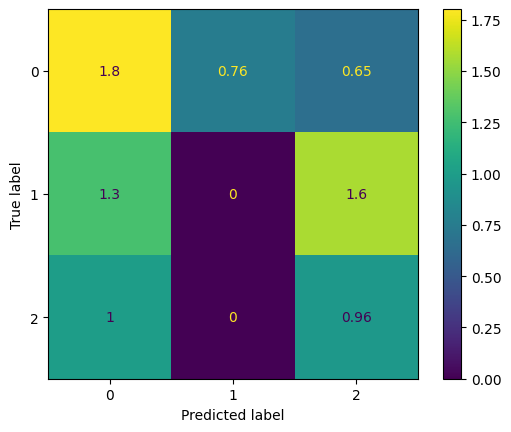

: 

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)

model=XGBoost(X_train,y_train,X_test,y_test,True)
modelP=XGBoostP(X_train,y_train,X_test,y_test,True)